In [6]:
!pip install tabulate

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from tabulate import tabulate

In [3]:
# Download Bitcoin data from Yahoo Finance
btc_data = yf.download("BTC-USD", start="2021-01-01", end="2022-01-01")
price_series = btc_data['Close']

[*********************100%***********************]  1 of 1 completed


Ticker           BTC-USD
Date                    
2021-01-01  29374.152344
2021-01-02  32127.267578
2021-01-03  32782.023438
2021-01-04  31971.914062
2021-01-05  33992.429688
...                  ...
2021-12-27  50640.417969
2021-12-28  47588.855469
2021-12-29  46444.710938
2021-12-30  47178.125000
2021-12-31  46306.445312

[365 rows x 1 columns]


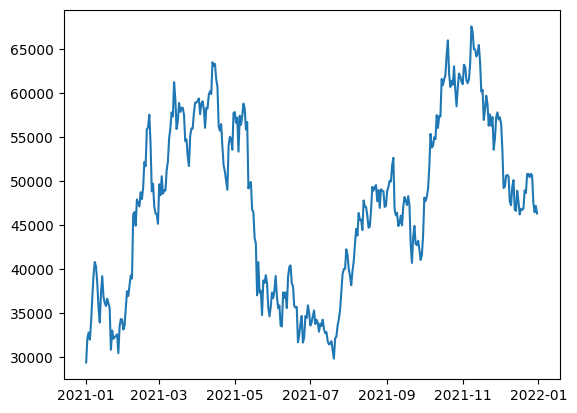

In [4]:
print(price_series)
plt.plot(price_series)
plt.show()

In [9]:
# Use 'Adj Close' if available; otherwise, fall back to 'Close'
if 'Adj Close' in btc_data.columns:
    price_series = btc_data['Adj Close']
else:
    price_series = btc_data['Close']

price_series = price_series.dropna()

# Compute log returns (in percent)
returns = 100 * np.log(price_series / price_series.shift(1)).dropna()

# Define grids for model parameters
mean_models = ['Constant', 'AR']
vol_models = ['GARCH', 'EGARCH']
dists = ['normal', 't']

results = []

for mean in mean_models:
    for vol in vol_models:
        for dist in dists:
            print(f"Fitting model with mean: {mean}, vol: {vol}, dist: {dist}")
            lags = 1 if mean == 'AR' else 0

            # -----------------------------
            # Fit the full model on the complete dataset
            try:
                model_full = arch_model(returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res_full = model_full.fit(disp='off')
                # Extract the last 5 in-sample estimated conditional volatility values as a list
                last5_cond_vol = res_full.conditional_volatility.iloc[-5:].tolist()
                # Use the 5th from last estimated volatility as the "actual sigma"
                actual_sigma = res_full.conditional_volatility.iloc[-5]
            except Exception as e:
                last5_cond_vol = f"Error: {e}"
                actual_sigma = None

            # -----------------------------
            # Fit the model on the training dataset (excluding the last 5 observations)
            try:
                train_returns = returns.iloc[:-5]
                model_train = arch_model(train_returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res_train = model_train.fit(disp='off')
                # For EGARCH, use simulation-based forecasting (analytic forecasts for horizon > 1 are not available)
                if vol == 'EGARCH':
                    forecast_train = res_train.forecast(horizon=5, method='simulation', simulations=500, reindex=False)
                else:
                    forecast_train = res_train.forecast(horizon=5, reindex=False)
                # The forecasted variance for each horizon is in an array;
                # take the square root to obtain forecasted volatility for each day.
                vol_forecast_train = np.sqrt(forecast_train.variance.values[-1, :])
                # Take the 5-step ahead forecast (i.e. last element) as the forecast sigma
                forecast_sigma = vol_forecast_train[-1]
            except Exception as e:
                forecast_sigma = f"Error: {e}"

            # -----------------------------
            # Compute the forecast error as the absolute difference between the actual sigma and the forecast sigma
            try:
                if isinstance(actual_sigma, (float, np.float64)) and isinstance(forecast_sigma, (float, np.float64)):
                    forecast_error = abs(actual_sigma - forecast_sigma)/actual_sigma
                else:
                    forecast_error = None
            except Exception as e:
                forecast_error = f"Error: {e}"

            # Collect the results in a dictionary
            results.append({
                "Mean": mean,
                "Volatility": vol,
                "Distribution": dist,
                "Last 5 Cond Vol": last5_cond_vol,
                "Actual sigma (from full)": actual_sigma,
                "Forecast sigma (from train)": forecast_sigma,
                "Forecast Error": forecast_error
            })

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results)

# Print the results as a formatted table using tabulate
print(tabulate(results_df, headers='keys', tablefmt='psql', showindex=False))

Fitting model with mean: Constant, vol: GARCH, dist: normal
Fitting model with mean: Constant, vol: GARCH, dist: t
Fitting model with mean: Constant, vol: EGARCH, dist: normal
Fitting model with mean: Constant, vol: EGARCH, dist: t
Fitting model with mean: AR, vol: GARCH, dist: normal
Fitting model with mean: AR, vol: GARCH, dist: t
Fitting model with mean: AR, vol: EGARCH, dist: normal
Fitting model with mean: AR, vol: EGARCH, dist: t
+----------+--------------+----------------+------------------------------------------------------------------------------------------------------+----------------------------+-------------------------------+------------------+
| Mean     | Volatility   | Distribution   | Last 5 Cond Vol                                                                                      |   Actual sigma (from full) |   Forecast sigma (from train) |   Forecast Error |
|----------+--------------+----------------+------------------------------------------------------------